## DEPRECATED
This code logic is deprecated because the spotify endpoints used were disabled and cannot be used anymore

In [2]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import plotly.express as px

load_dotenv()

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials())

/Users/tamino/Projects/hslu/dspro/dspro1/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


First we fetch the data

In [4]:
results = sp.playlist_items('5Rh7ikX5dteMXfc8tmeBJy')

song_ids = map(lambda song : song['track']['id'], results['items'])

features = sp.audio_features(song_ids)

raw_data = [{**song, 'features': features} for song, features in zip(results['items'], features)]

HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=1uvyZBs4IZYRebHIB1747m,3S2R0EVwBSAVMd5UMgKTL0,2374M0fQpWi3dLnB54qaLX,4RvWPyQ5RL0ao9LPZeSouE,2MuWTIM3b0YEAskbeeFE1i,2fuCquhmrzHpu5xcA1ci9x,2WfaOiMkCvy7F5fcp2zZ8L,37ZJ0p5Jm13JPevGcx4SkF,77NNZQSqzLNqh2A9JhLRkg,4N0fzRX3T7QkOecp3pkWpp,4CeeEOM32jQcH3eN9Q2dGj,6MdqqkQ8sSC0WB4i8PyRuQ,4r8lRYnoOGdEi6YyI5OC1o,57bgtoPSgt236HzfBOd8kj,47BBI51FKFwOMlIiX6m8ya,0hrBpAOgrt8RXigk83LLNE,1Jaah2tmN9Hv81A87KZ1MU,1qPbGZqppFwLwcBC1JQ6Vr,1WYEDcS7WGjv0rG7rmMX3o,7H6ev70Weq6DdpZyyTmUXk,1QV6tiMFM6fSOKOGLMHYYg,3DQVgcqaP3iSMbaKsd57l5,5VGlqQANWDKJFl0MBG3sg2,0KQx6HOpJueiSkztcS0r7D,3TCauNPqFiniaYHBvEVoHG,7IdFdRlCjUi6kkhbPoRfnw,1vxw6aYJls2oq3gW0DujAo,1ixbwbeBi5ufN4noUKmW5a,3dPQuX8Gs42Y7b454ybpMR,1L5tZi0izXsi5Kk5OJf4W0,4OSBTYWVwsQhGLF9NHvIbR,3iVcZ5G6tvkXZkZKlMpIUs,3DK6m7It6Pw857FcQftMds,3e9HZxeyfWwjeyPAMmWSSQ,58q2HKrzhC3ozto2nDdN4z,4SDWMFvYJKtK1QPhIOeZhd,0wwPcA6wtMf6HUMpIRdeP7,0F7FA14euOIX8KcbEturGH,2VxeLyX666F8uXCJ0dZF8B,2Foc5Q5nqNiosCNqttzHof,3z8h0TU7ReD

SpotifyException: http status: 403, code:-1 - https://api.spotify.com/v1/audio-features/?ids=1uvyZBs4IZYRebHIB1747m,3S2R0EVwBSAVMd5UMgKTL0,2374M0fQpWi3dLnB54qaLX,4RvWPyQ5RL0ao9LPZeSouE,2MuWTIM3b0YEAskbeeFE1i,2fuCquhmrzHpu5xcA1ci9x,2WfaOiMkCvy7F5fcp2zZ8L,37ZJ0p5Jm13JPevGcx4SkF,77NNZQSqzLNqh2A9JhLRkg,4N0fzRX3T7QkOecp3pkWpp,4CeeEOM32jQcH3eN9Q2dGj,6MdqqkQ8sSC0WB4i8PyRuQ,4r8lRYnoOGdEi6YyI5OC1o,57bgtoPSgt236HzfBOd8kj,47BBI51FKFwOMlIiX6m8ya,0hrBpAOgrt8RXigk83LLNE,1Jaah2tmN9Hv81A87KZ1MU,1qPbGZqppFwLwcBC1JQ6Vr,1WYEDcS7WGjv0rG7rmMX3o,7H6ev70Weq6DdpZyyTmUXk,1QV6tiMFM6fSOKOGLMHYYg,3DQVgcqaP3iSMbaKsd57l5,5VGlqQANWDKJFl0MBG3sg2,0KQx6HOpJueiSkztcS0r7D,3TCauNPqFiniaYHBvEVoHG,7IdFdRlCjUi6kkhbPoRfnw,1vxw6aYJls2oq3gW0DujAo,1ixbwbeBi5ufN4noUKmW5a,3dPQuX8Gs42Y7b454ybpMR,1L5tZi0izXsi5Kk5OJf4W0,4OSBTYWVwsQhGLF9NHvIbR,3iVcZ5G6tvkXZkZKlMpIUs,3DK6m7It6Pw857FcQftMds,3e9HZxeyfWwjeyPAMmWSSQ,58q2HKrzhC3ozto2nDdN4z,4SDWMFvYJKtK1QPhIOeZhd,0wwPcA6wtMf6HUMpIRdeP7,0F7FA14euOIX8KcbEturGH,2VxeLyX666F8uXCJ0dZF8B,2Foc5Q5nqNiosCNqttzHof,3z8h0TU7ReDPLIbEnYhWZb,4UDmDIqJIbrW0hMBQMFOsM,5CQ30WqJwcep0pYcV4AMNc,0GjEhVFGZW8afUYGChu3Rr,0ofHAoxe9vBkTCp2UQIavz,4xHWH1jwV5j4mBYRhxPbwZ,40riOy7x9W7GXjyGp4pjAv,4N0TP4Rmj6QQezWV88ARNJ,2grjqo0Frpf2okIBiifQKs,2SpEHTbUuebeLkgs9QB7Ue,2IJftBfq7pJ43tfnOR0RB3,0DfG1ltJnZyq4Tx3ZLL7ZU,5vZ4IeUenK2cHub2d7yfWk,3NIDOSThELMihLSOMZcL4k,5LH1z4ma2TN2aVeESXthj9,228BxWXUYQPJrJYHDLOHkj,6mICuAdrwEjh6Y6lroV2Kg,5w9c2J52mkdntKOmRLeM2m,4sCSUQnWQ6HJsOMjfPicdn,3i3fYhl23l7exbIj9oAJPN,1MqzIgGsHP4cNjPboevsfq,34dx8DACTJsc3rsJdaEIQw,6RU0eIObzPf9HxYYV2hh5G,2d8D7uk3tbAThjRkdfrx9c,6IRA4KOVbtiGiTdYoEThJN,7sXTcibuNYugjjYNfgf2kY,2S7RApTsKT0CtYojYq2cKz,776AftMmFFAWUIEAb3lHhw,5zyrEv4F3FaLECI8TOKpFM,0jLeyuu6mtsD384054xLah,1vePC77pxGSUXLErDHuGtH,5Tbpp3OLLClPJF8t1DmrFD,5n8Aro6j1bEGIy7Tpo7FV7,7MJQ9Nfxzh8LPZ9e9u68Fq,7iL6o9tox1zgHpKUfh9vuC,0cGG2EouYCEEC3xfa0tDFV,39lSeqnyjZJejRuaREfyLL,4OdhffpvG3HxDJMxYOKh97,0qi4b1l0eT3jpzeNHeFXDT,3L7RtEcu1Hw3OXrpnthngx,7ACxUo21jtTHzy7ZEV56vU,78lgmZwycJ3nzsdgmPPGNx,5sICkBXVmaCQk5aISGR3x1,3CIOopLwvyMvXk97ZEksKO,54yLLvpezvPO1lA3GspiZj,0WtDGnWL2KrMCk0mI1Gpwz,0FZvjrHpAmLKj574M4VwrF,3NWTRZ0A8xKlBP1qgNftql,6g0Orsxv6glTJCt4cHsRsQ,4pAl7FkDMNBsjykPXo91B3,2YWjW3wwQIBLNhxWKBQd16,7BKLCZ1jbUBVqRi2FVlTVw,5knuzwU65gJK7IF5yJsuaW,0TDLuuLlV54CkRRUOahJb4,0nrRP2bk19rLc0orkWPQk2,1hwJKpe0BPUsq6UUrwBWTw,6md4w95cnKaW64JyEQ3A0L,60a0Rd6pjrkxjPbaKzXjfq,6qa36OkEeQqGaWlOcpjlGD,3Fcfwhm8oRrBvBZ8KGhtea:
 None, reason: None

Then extract all interesting / relevant data

In [4]:
df = pd.DataFrame(columns=['id', 'name', 'artist', 'album', 'release_year', 'explicit', 'popularity', 'duration', 'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence'])

for idx, item in enumerate(raw_data):
    track = item['track']
    features = item['features']

    df.loc[idx] = [
        track['id'],                             # string
        track['name'],                           # string
        track['artists'][0]['name'],             # string
        track['album']['name'],                  # string
        int(track['album']['release_date'][:4]), # integer         year
        int(track['explicit']),                  # integer  0|1    (boolean)
        track['popularity'],                     # integer  0-100  % (current trendiness)
        track['duration_ms'],                    # integer
        features['acousticness'],                # float    0-1    probability (whether the track uses instrumental rather than electric sounds)
        features['danceability'],                # float    0-1    probability (suitability for dancing)
        features['energy'],                      # float    0-1    % (intensity / activity)
        features['instrumentalness'],            # float    0-1    probability (whether the track contains no vocals)
        features['key'],                         # integer  -1-11  (-1: none identified, 0: C, ...)
        features['liveness'],                    # float    0-1    probability (whether the song is a live performance)
        features['loudness'],                    # float           dB
        features['mode'],                        # integer  0|1    (0: minor or 1: major)
        features['speechiness'],                 # float    0-1    % (how many words are spoken rather than sang)
        features['tempo'],                       # float           BPM
        features['time_signature'],              # integer  3-7    time signature (x/4, example: 3/4)
        features['valence'],                     # float    0-1    spectrum (0: sad / angry, 1: happy)
    ]

To analyze all audio features we visualize all fields with information about the tracks audio

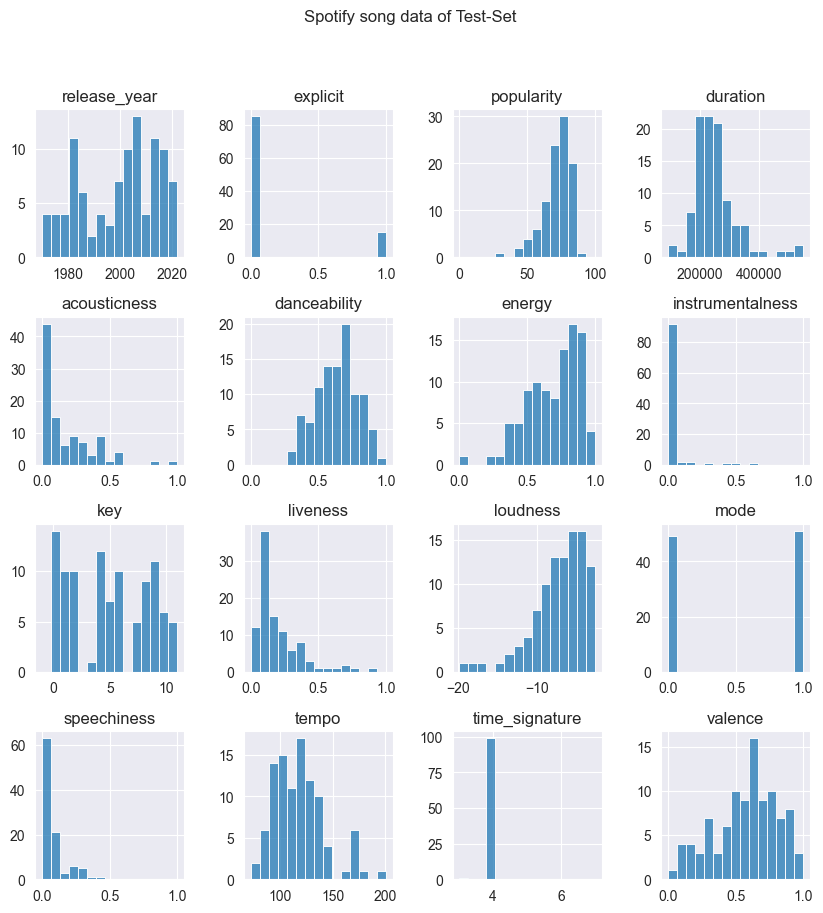

In [5]:
columns = [
    'release_year',
    'explicit',
    'popularity',
    'duration',
    'acousticness',
    'danceability',
    'energy',
    'instrumentalness',
    'key',
    'liveness',
    'loudness',
    'mode',
    'speechiness',
    'tempo',
    'time_signature',
    'valence',
]

x_ranges = [
    [],
    [0, 1],
    [0, 100],
    [],
    [0, 1],
    [0, 1],
    [0, 1],
    [0, 1],
    [-1, 11],
    [0, 1],
    [],
    [0, 1],
    [0, 1],
    [],
    [3, 7],
    [0, 1],
]

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i, column in enumerate(columns):
    ax = axes[i // 4, i % 4]

    data = df[column]
    x_range = x_ranges[i]
    
    data_range = None
    if len(x_range) == 2:
        data_range = [x_range[0], x_range[1]]

    sns.histplot(data, bins=15, ax=ax, binrange=data_range)
    ax.set_title(column)
    ax.set_xlabel('')
    ax.set_ylabel('')

#axes[3, 2].axis('off')
#axes[3, 3].axis('off')

plt.suptitle('Spotify song data of Test-Set')

plt.show()

# Which features do we need?

## Popularity
- **<span color='#e74c3c'>irrelevant</span>**
- **<span color='#e67e22'>probably irrelevant</span>**
- **<span color='#f1c40f'>maybe important</span>**
- **<span color='#2ecc71'>important</span>**

## Instrumentalness
- **<span color='#e67e22'>probably irrelevant</span>**

In [6]:
purged = df.drop([
    'popularity',
    'duration',
    'instrumentalness',
    'liveness',
    'time_signature',
], axis='columns')

print(purged.columns)

Index(['id', 'name', 'artist', 'album', 'release_year', 'explicit',
       'acousticness', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'tempo', 'valence'],
      dtype='object')


In [7]:
scaler = MinMaxScaler()

normalization_columns = ['release_year', 'key', 'loudness', 'tempo']
for column in normalization_columns:
    purged[column] = scaler.fit_transform(purged[[column]])

In [8]:
ids = purged['id']
names = purged['name'] + ' - ' + purged['artist']

purged = purged.drop([
    'id',
    'name',
    'artist',
    'album',
], axis='columns')

In [11]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(purged)

pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])

In [40]:
fig = px.scatter(pca_df, x='PC1', y='PC2')

fig.update_traces(
    text=names,
    hovertemplate='%{text}',
    mode='markers'
)

fig.show()

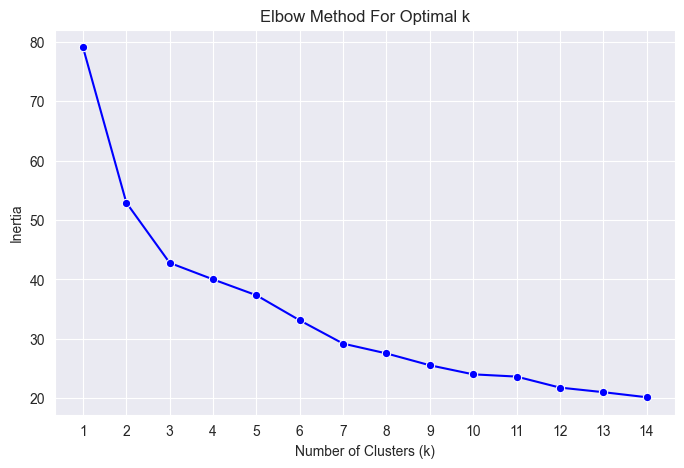

In [25]:
inertia = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(purged)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method results with Seaborn
plt.figure(figsize=(8, 5))
sns.lineplot(x=K, y=inertia, marker='o', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(K)
plt.show()

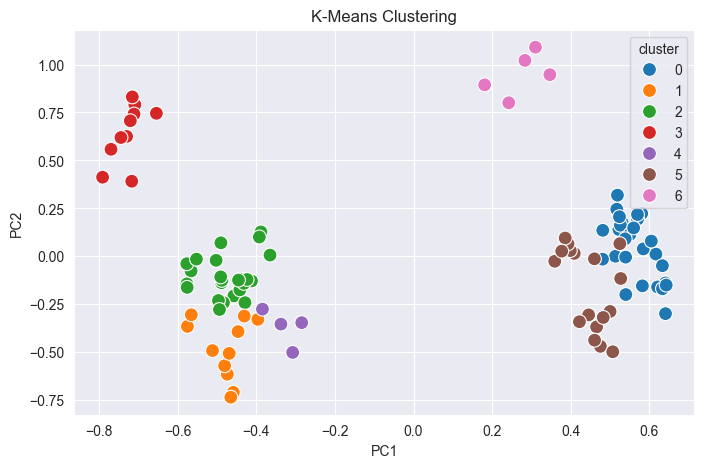

In [26]:
k = 7
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(purged)

pca_df['cluster'] = kmeans.labels_

plt.figure(figsize=(8, 5))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='tab10', s=100)
plt.title('K-Means Clustering')
plt.show()


In [32]:
pca_df['name'] = names
pca_df['personal_cluster'] = [1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 5, 2, 3, 4, 1, 4, 4, 1, 4, 2, 1, 1, 4, 4, 5, 1, 4, 1, 4, 4, 5, 5, 4, 4, 4, 4, 6, 4, 2, 1, 1, 1, 4, 4, 1, 1, 1, 1, 4, 4, 1, 3, 4, 4, 2, 4, 2, 2, 4, 4, 2, 4, 1, 6, 4, 4, 3, 4, 4, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 4, 4, 4, 4, 2, 4, 2, 2, 2, 1, 4, 1, 1, 1]

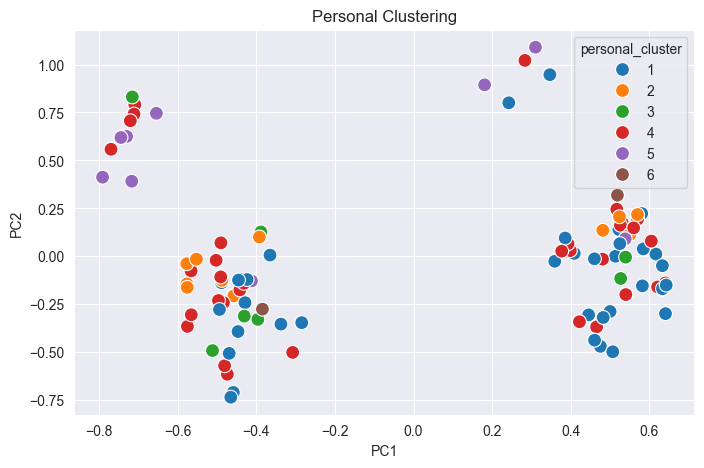

In [33]:
plt.figure(figsize=(8, 5))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='personal_cluster', palette='tab10', s=100)
plt.title('Personal Clustering')
plt.show()

In [1]:
from data_preparation.plot import scatter

scatter(pca_df)

NameError: name 'pca_df' is not defined

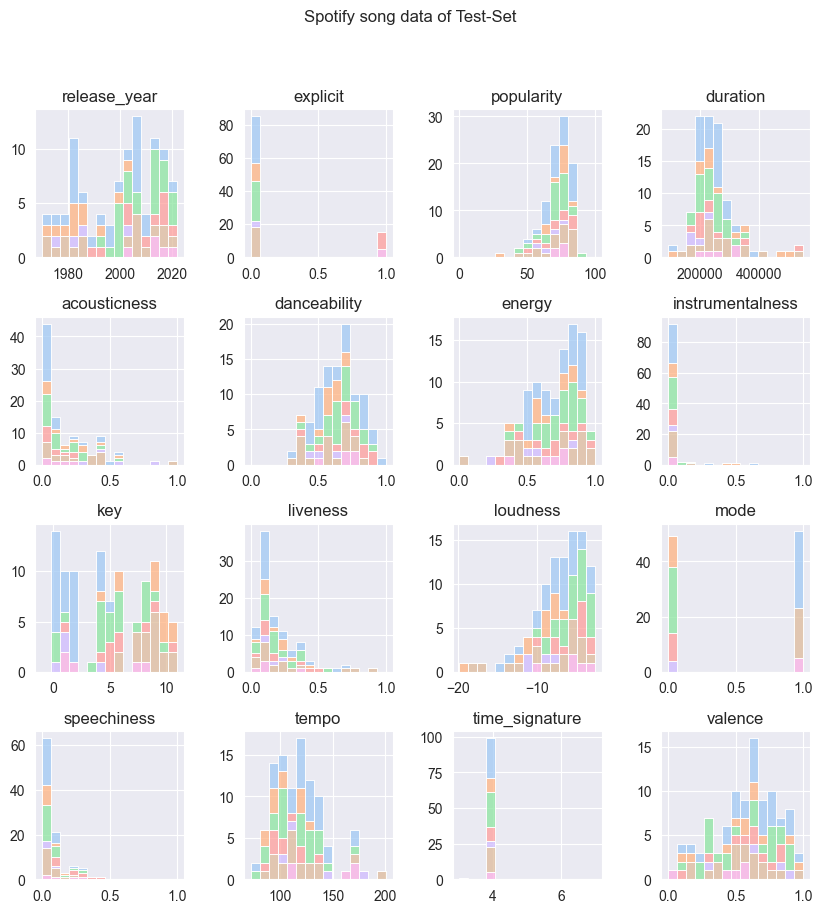

In [50]:
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i, column in enumerate(columns):
    ax = axes[i // 4, i % 4]

    # data = pd.concat([df[column], pca_df['personal_cluster']], axis=1)
    data = pd.concat([df[column], pca_df['cluster']], axis=1)
    x_range = x_ranges[i]
    
    data_range = None
    if len(x_range) == 2:
        data_range = [x_range[0], x_range[1]]

    sns.histplot(data, ax=ax, stat="count", multiple="stack",
             x=column,
             bins=15, binrange=data_range,
             palette="pastel", hue="cluster",
             element="bars", legend=False)
    ax.set_title(column)
    ax.set_xlabel('')
    ax.set_ylabel('')

#axes[3, 2].axis('off')
#axes[3, 3].axis('off')

plt.suptitle('Spotify song data of Test-Set')

plt.show()

findings:
k-means primarily used the features "explicit" and "mode" to cluster the songs. both of those don't tell much about the song imo

In [51]:
purged.columns

Index(['release_year', 'explicit', 'acousticness', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'tempo', 'valence'],
      dtype='object')

In [52]:
purged = purged.drop([
    'explicit',
    'key',
    'mode',
    'release_year',
], axis='columns')

In [53]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(purged)

pca_df = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])

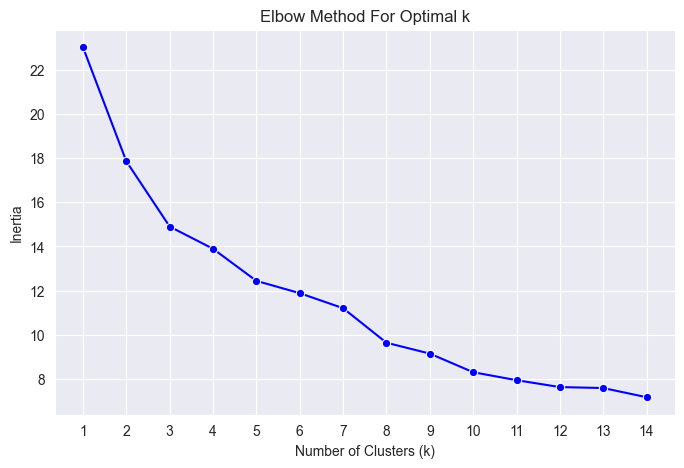

In [54]:
inertia = []
K = range(1, 15)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(purged)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Method results with Seaborn
plt.figure(figsize=(8, 5))
sns.lineplot(x=K, y=inertia, marker='o', color='b')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.xticks(K)
plt.show()

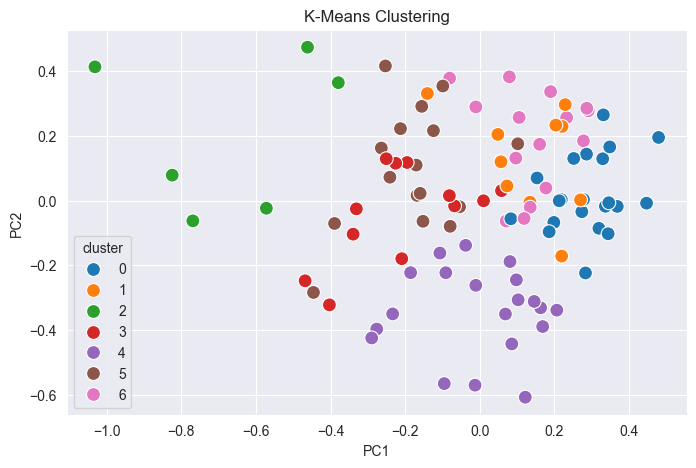

In [55]:
k = 7
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(purged)

pca_df['cluster'] = kmeans.labels_

plt.figure(figsize=(8, 5))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='tab10', s=100)
plt.title('K-Means Clustering')
plt.show()


In [56]:
fig = px.scatter(pca_df, x='PC1', y='PC2')

fig.update_traces(
    text=names,
    hovertemplate='%{text}',
    mode='markers'
)

fig.show()